In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from datetime import datetime

import hvplot.pandas 
import seaborn as sns

### Load data

In [2]:
df = pd.read_csv('bow_calibration_resultlog.tsv', sep='\\t', engine = "python")
df.head()
cols = np.array(df.columns)

### Data cleaning

In [3]:
# Use regex to find columns patterns
#drop apt_logs
regex = r'^apt_log*'
atp_log_columns = df.columns[df.columns.str.match(regex)]

#drop images results
regex_images = r'^image_*'
images_columns = df.columns[df.columns.str.match(regex_images)]

#dop analyze LED
regex_led = r'^analyze_led*'
led_columns = df.columns[df.columns.str.match(regex_led)]

#drop verify results
regex_verify = r'^verify_*'
verify_columns = df.columns[df.columns.str.match(regex_verify)]

# Drop the columns using the regex-matched columns
df = df.drop(columns=atp_log_columns)
df = df.drop(columns=images_columns)
df = df.drop(columns=led_columns)
df = df.drop(columns=verify_columns)

df = df.drop(columns=["system", 
                      "file_name", 
                      "epoch_stamp", 
                      "unit_partno", 
                      "unit_revision", 
                      "git_status", 
                      "operator_rfid", 
                      "operator_log-operator_id",
                      "operator_log-operator_id_result",
                      "month"
                      ])

#filter golden units
df = df.drop(index=df[df['unit_serial'] == 'TG03G-G00000000001'].index)
df = df.drop(index=df[df['unit_serial'] == 'TG03G-G00000000002'].index)
df = df.drop(index=df[df['unit_serial'] == 'TG03G-G00000000003'].index)
df = df.drop(index=df[df['unit_serial'] == 'TG03G-G00000000000'].index)

cols = np.array(df.columns)

# Split time stamp
df[['date', 'time']] = df['time_stamp'].str.split('_', expand=True)

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
# Convert 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'], format="%H%M%S")

# Covert time stamp directly into date time
df['time_stamp'] = df['time_stamp'].str.replace('_', '')
df['date_time'] = pd.to_datetime(df['date'], format= "%Y%m%d%H%M%S") 

### Divide the DataFrame into 3 datasets

In [4]:
# Use regex to find columns starting with calibrate, features, straylight

regex_calibrate = r'^calibrate_*'
regex_features = r'^features_*'
regex_straylight = r'^straylight_*'

calibrate_columns = df.columns[df.columns.str.match(regex_calibrate)]
features_columns = df.columns[df.columns.str.match(regex_features)]
straylight_columns = df.columns[df.columns.str.match(regex_straylight)]

# Calibration dataset
df_calibration = df.drop(columns=features_columns)
df_calibration = df_calibration.drop(columns=straylight_columns)


# Features dataset
df_features = df.drop(columns=calibrate_columns)
df_features = df_features.drop(columns=straylight_columns)

# Straylight dataset
df_straylight = df.drop(columns=calibrate_columns)
df_straylight = df_straylight.drop(columns=features_columns)

### Analysis of the entire dataset

In [5]:
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

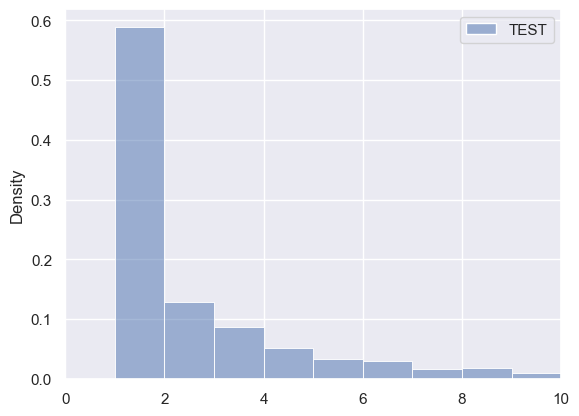

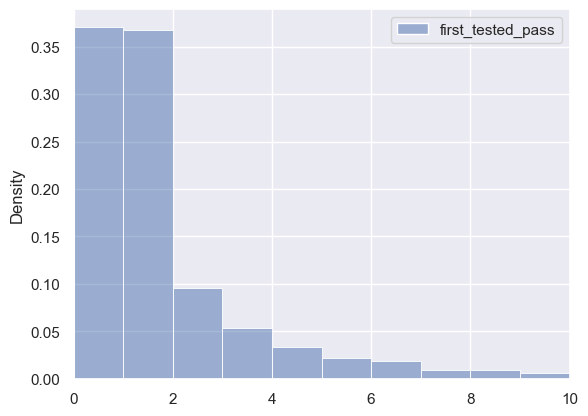

In [6]:
# count the number of tests per unit
sns.histplot(pd.DataFrame(df.groupby(["unit_serial"])["TEST"].count().reset_index()),
              bins = 50, binwidth = 1, stat = "density")
plt.xlim(0,10)
plt.show()
plt.close()
# count the number of first tested pass per unit
sns.histplot(pd.DataFrame(df.groupby(["unit_serial"])["first_tested_pass"].count().reset_index()),
              bins = 50, binwidth = 1, stat = "density")
plt.xlim(0,10)
plt.show()
plt.close()

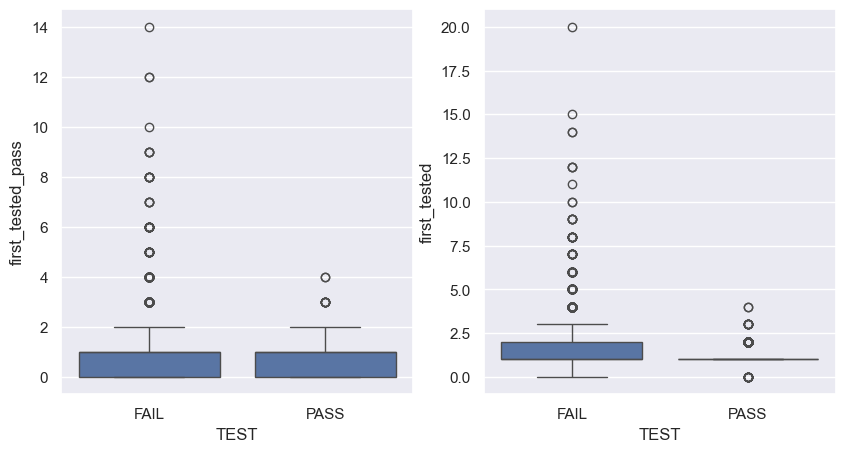

In [7]:
# Group by 'date' and 'first_tested_pass', and count the occurrences
df_grouped = df.groupby(["unit_serial", "TEST", "date_time"])[["first_tested_pass", "first_tested"]].count().reset_index()
df_grouped.head()

# Box plot for the tests results in first tested pass and first tested
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(df_grouped, x = "TEST", y = "first_tested_pass")
plt.subplot(1,2,2)
sns.boxplot(df_grouped, x = "TEST", y = "first_tested")
plt.show()
plt.close()

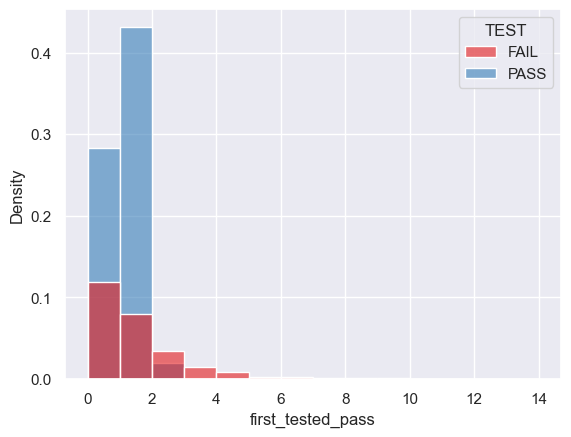

In [8]:
# Histogram of test results
sns.histplot(df_grouped, x = "first_tested_pass",
              hue = "TEST",
              binwidth = 1,
              stat="density",
              alpha = 0.6,
              palette="Set1")
plt.show()
plt.close()

In [9]:
#Interactive plot of the test results
df_grouped.hvplot.hist("first_tested_pass", by = "TEST", subplots = True, width = 500, bins = 14)

:NdLayout   [TEST]
   :Histogram   [first_tested_pass]   (Count)

### Analysis of the calibration dataset

In [10]:
#drop duplicates
df_calibration["first_tested_pass"] = df_calibration["first_tested_pass"].round()
df_calibration = df_calibration.drop_duplicates(subset=["first_tested_pass", "unit_serial"])

In [11]:
#Calibration result count
df_calibration_results = df_calibration.filter([
             "calibrate_cam0-calculation_result",
             "calibrate_cam0-offset_x_result",
             "calibrate_cam0-offset_y_result",
             "calibrate_cam0-delta_z_result",
             "calibrate_cam0-delta_xy_result",
             "calibrate_cam0-limit_result",
             "calibrate_cam1-calculation_result",
             "calibrate_cam1-offset_x_result",
             "calibrate_cam1-offset_y_result",
             "calibrate_cam1-delta_z_result",
             "calibrate_cam1-delta_xy_result",
             "calibrate_cam1-limit_result",
             "calibrate_cam2-calculation_result",
             "calibrate_cam2-offset_x_result",
             "calibrate_cam2-offset_y_result",
             "calibrate_cam2-deltaz_result",
             "calibrate_cam2-delta_z_result",
             "calibrate_cam2-delta_xy_result",
             "calibrate_cam2-limit_result",
             "calibrate_cam3-calculation_result",
             "calibrate_cam3-offset_x_result",
             "calibrate_cam3-offset_y_result",
             "calibrate_cam3-delta_xy_result",
             "calibrate_cam3-deltaz_result",
             "calibrate_cam3-limit_result",
            ])
df_calibration_results = df_calibration_results.melt(var_name = "Test", value_name = "Result")
df_calibration_results["Result"] = df_calibration_results["Result"].fillna("Missing")

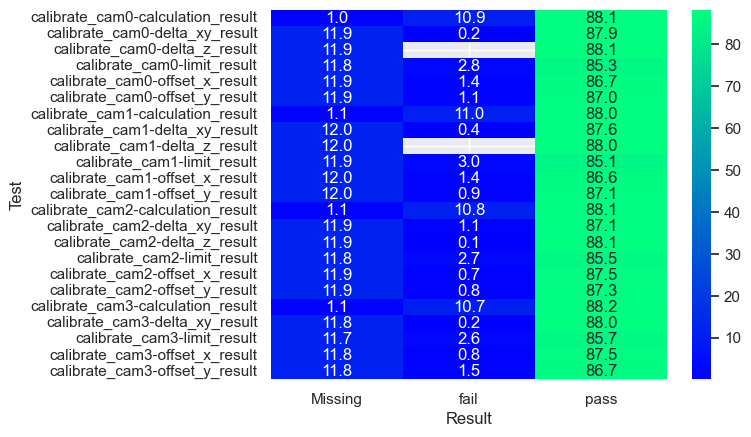

In [12]:
# Calculate the total number of occurrences for each test
total_occurrences = df_calibration_results.groupby('Test')['Result'].count()

# Calculate the percentages for pass, fail, and missing results
df_calibration_results['Percentage'] = df_calibration_results.groupby(['Test', 'Result'])['Result'].transform(lambda x: (x.count() / total_occurrences.loc[x.name[0]]) * 100)

# Cross table results and heatmap for each test and type of result
crosstab = pd.crosstab(df_calibration_results["Test"], df_calibration_results["Result"], values=df_calibration_results["Percentage"], aggfunc = "mean")
sns.heatmap(crosstab, annot=True, fmt = '.1f', cmap='winter')
plt.show()
plt.close()

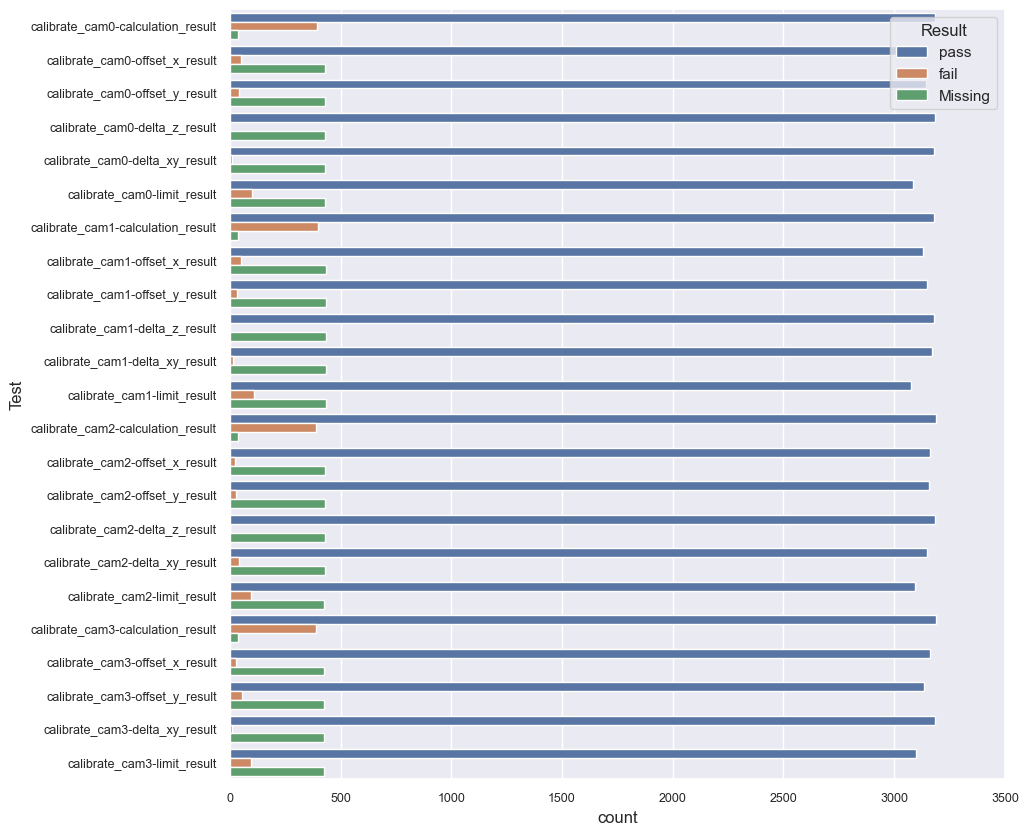

In [13]:
# Count the number of results for each test
plt.figure(figsize=(10,10))
sns.countplot(df_calibration_results, y = "Test", hue = "Result")
plt.xticks(size = 9)
plt.yticks(size = 9)
plt.xlim(0, 3500)
plt.show()
plt.close()

In [14]:
df_calibration_values = df_calibration.filter([
    "calibrate_cam0-offset_x",
    "calibrate_cam0-offset_y",
    "calibrate_cam0-delta_z",
    "calibrate_cam0-delta_xy", 
    "calibrate_cam1-offset_x",
    "calibrate_cam1-offset_y",
    "calibrate_cam1-delta_z",
    "calibrate_cam1-delta_xy",
    "calibrate_cam2-offset_x",
    "calibrate_cam2-offset_y",
    "calibrate_cam2-delta_z",
    "calibrate_cam2-delta_xy",
    "calibrate_cam3-offset_x",
    "calibrate_cam3-offset_y",
    "calibrate_cam3-delta_z",
    "calibrate_cam3-delta_xy",
    "TEST"
    ])
df_calibration_values.columns

Index(['calibrate_cam0-offset_x', 'calibrate_cam0-offset_y',
       'calibrate_cam0-delta_z', 'calibrate_cam0-delta_xy',
       'calibrate_cam1-offset_x', 'calibrate_cam1-offset_y',
       'calibrate_cam1-delta_z', 'calibrate_cam1-delta_xy',
       'calibrate_cam2-offset_x', 'calibrate_cam2-offset_y',
       'calibrate_cam2-delta_z', 'calibrate_cam2-delta_xy',
       'calibrate_cam3-offset_x', 'calibrate_cam3-offset_y',
       'calibrate_cam3-delta_z', 'calibrate_cam3-delta_xy', 'TEST'],
      dtype='object')

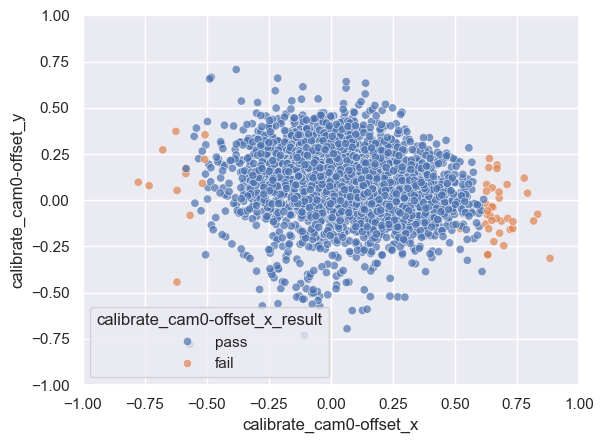

In [15]:
sns.scatterplot(df_calibration, x = "calibrate_cam0-offset_x", y = "calibrate_cam0-offset_y", hue = "calibrate_cam0-offset_x_result", alpha = 0.7)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()
plt.close()

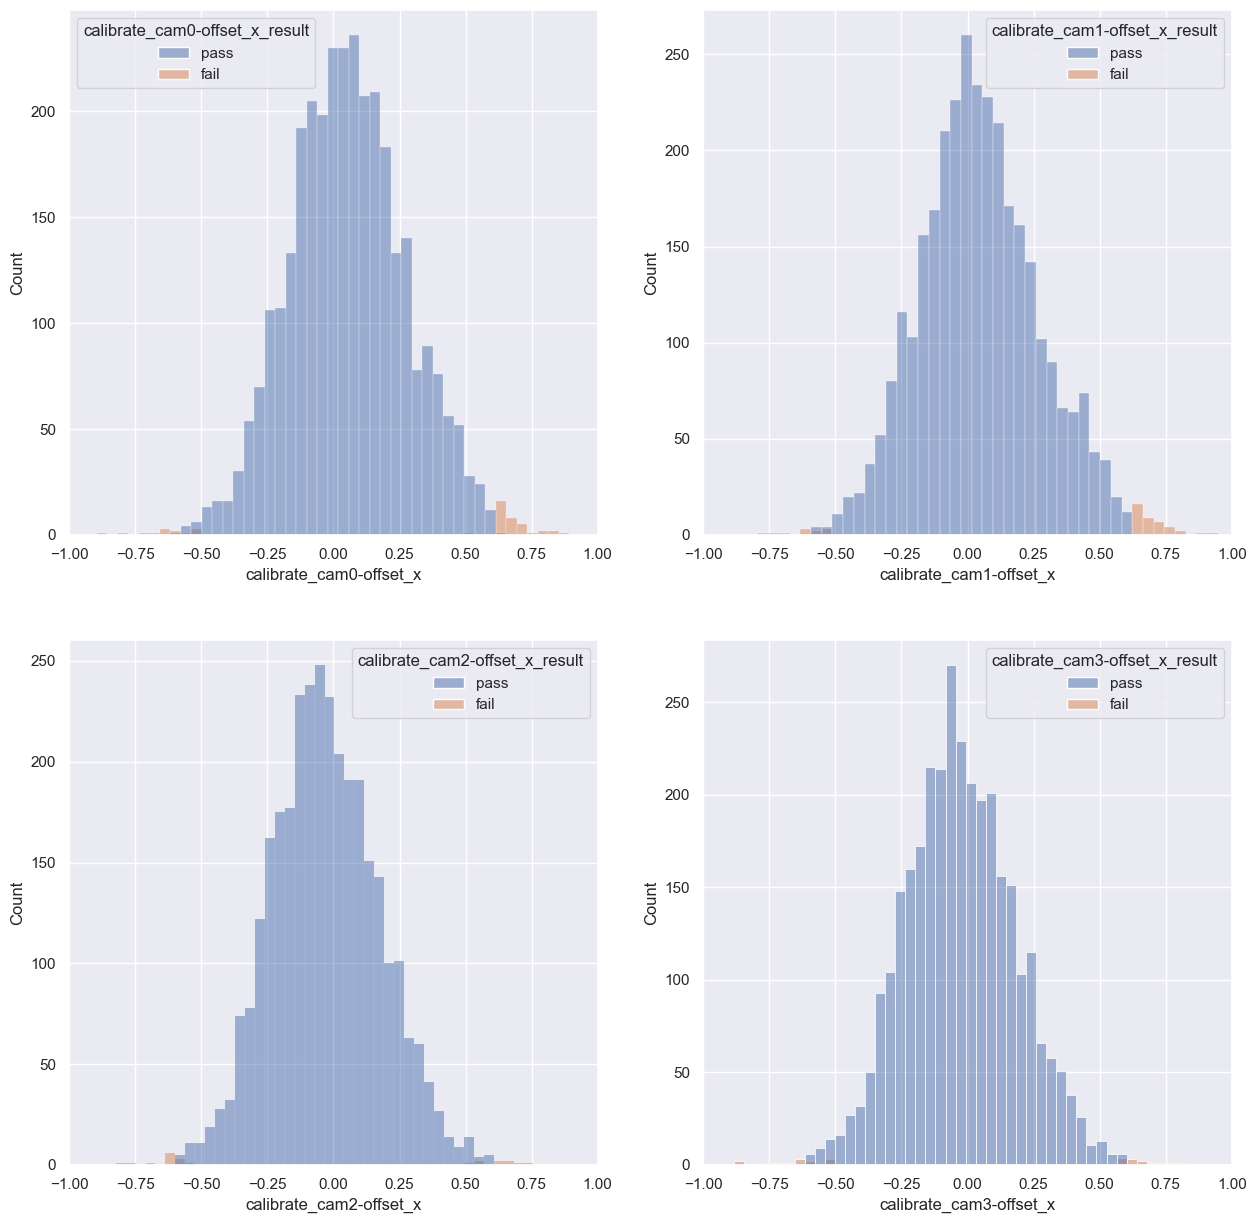

In [16]:
def analyzecam(cam, results):
    plt.figure(figsize=(15,15))
    counter = 1
    for i, j in zip(cam, results):
        plt.subplot(2, 2, counter)
        sns.histplot(df_calibration, x = df_calibration[i], hue = j, alpha = 0.5)
        plt.xlim(-1, 1)
        counter += 1
    plt.show()
    plt.close()

offsetx = ["calibrate_cam0-offset_x", "calibrate_cam1-offset_x", "calibrate_cam2-offset_x", "calibrate_cam3-offset_x"]
resultsx = ["calibrate_cam0-offset_x_result", "calibrate_cam1-offset_x_result", "calibrate_cam2-offset_x_result", "calibrate_cam3-offset_x_result"]

analyzecam(offsetx, resultsx)

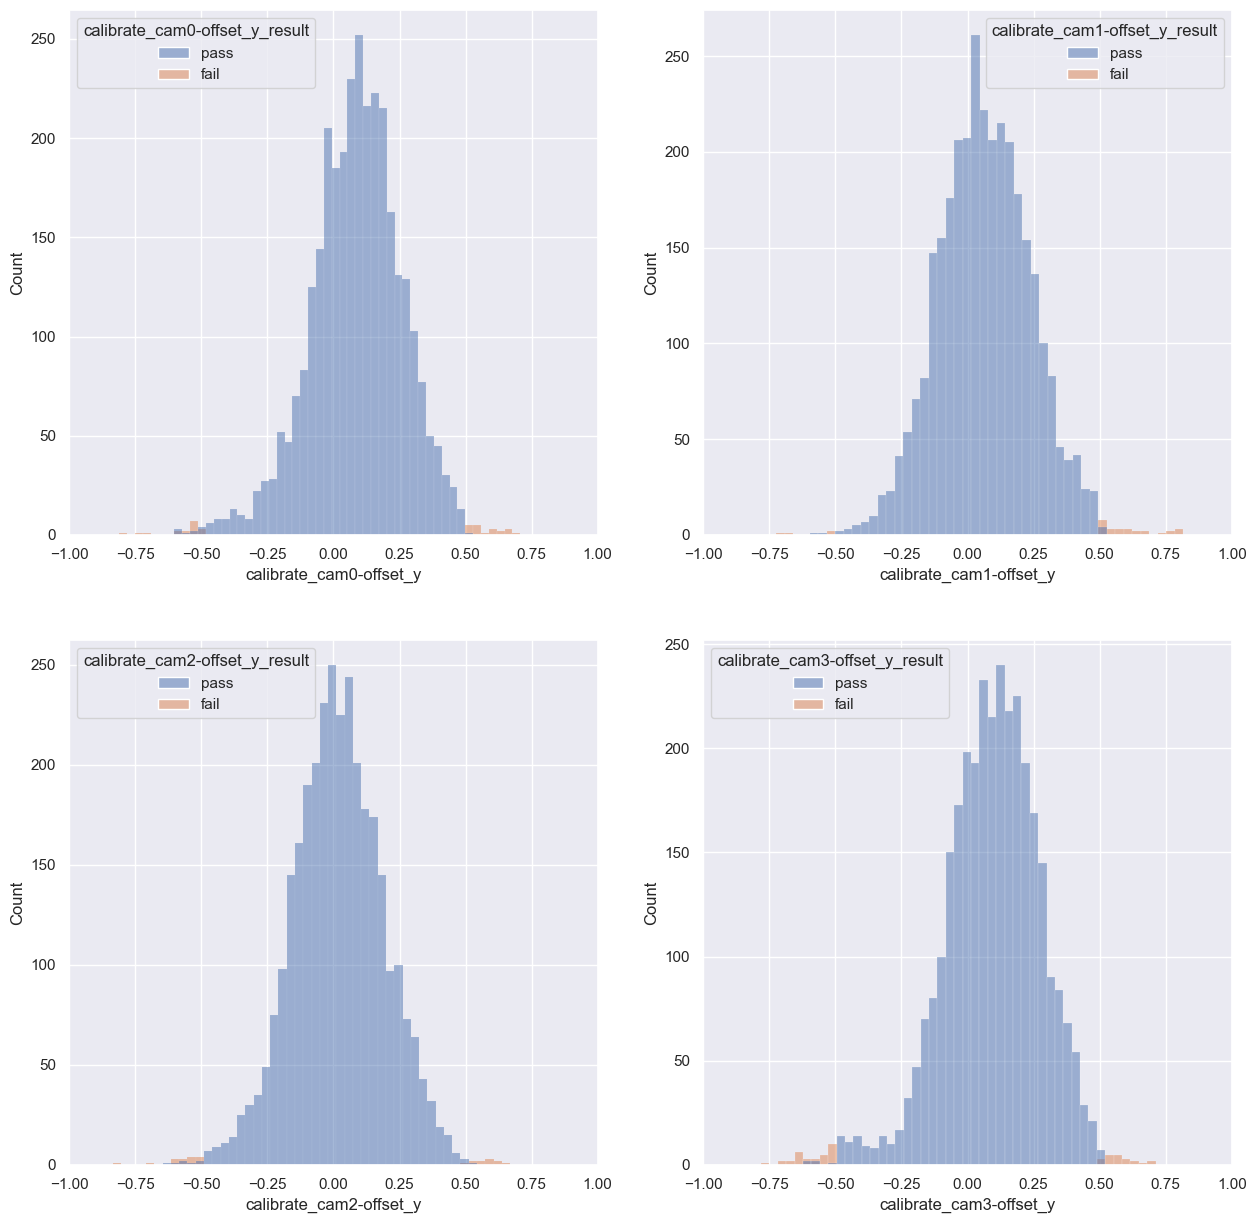

In [17]:
offsety = ["calibrate_cam0-offset_y", "calibrate_cam1-offset_y", "calibrate_cam2-offset_y", "calibrate_cam3-offset_y"]
resultsy = ["calibrate_cam0-offset_y_result", "calibrate_cam1-offset_y_result", "calibrate_cam2-offset_y_result", "calibrate_cam3-offset_y_result"]

analyzecam(offsety, resultsy)

In [18]:
#plot delta x and delta y values 
df_calibration_values_melted = df_calibration_values.melt(id_vars = ["TEST"], var_name= "Test_Type", value_name="Result", ignore_index = True)
df_calibration_values_melted.groupby(["Test_Type"])["Result"].mean()
df_calibration_values_melted["Std_dev"] = df_calibration_values_melted.groupby("Test_Type")["Result"].transform("std")
df_calibration_values_melted.head()

,TEST,Test_Type,Result,Std_dev
0,PASS,calibrate_cam0-offset_x,0.014055,0.254608
1,FAIL,calibrate_cam0-offset_x,NaN,0.254608
2,PASS,calibrate_cam0-offset_x,0.235182,0.254608
3,PASS,calibrate_cam0-offset_x,0.401371,0.254608
4,PASS,calibrate_cam0-offset_x,-0.494842,0.254608


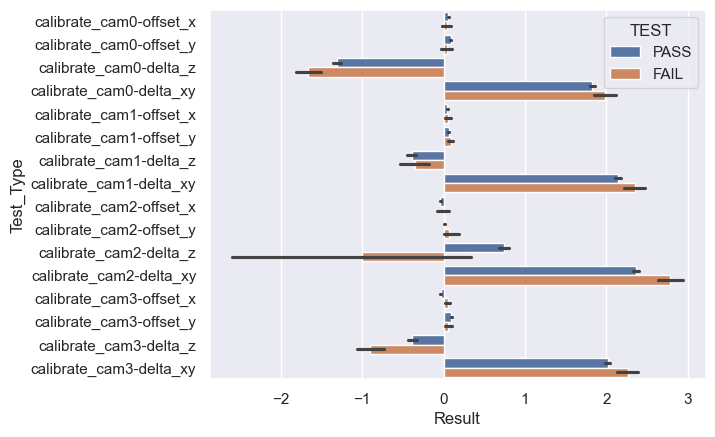

In [19]:
sns.barplot(df_calibration_values_melted, y = "Test_Type", x = "Result", hue = "TEST")
plt.show()
plt.close()

### Timeseries analysis

In [20]:
#Analysis by time
df_calibration["year"] = df_calibration["date"].dt.to_period('M')

df_cal_time = pd.DataFrame(df_calibration.groupby("year")["TEST"].value_counts().reset_index())

#Calculate the total number of occurrences for each test
total_tests = df_cal_time.groupby('year')["count"].sum()

# Calculate the percentages for each test in each year period
df_cal_time['percentage'] = df_cal_time.groupby(["year", "TEST"])['count'].transform(lambda x: (x / total_tests.loc[x.name[0]]) * 100)
df_cal_time.head()

,year,TEST,count,percentage
0,2020-06,PASS,12,85.714286
1,2020-06,FAIL,2,14.285714
2,2020-07,PASS,31,65.957447
3,2020-07,FAIL,16,34.042553
4,2020-08,PASS,55,88.709677


In [21]:
total_tests.loc["2020-06"]

np.int64(14)

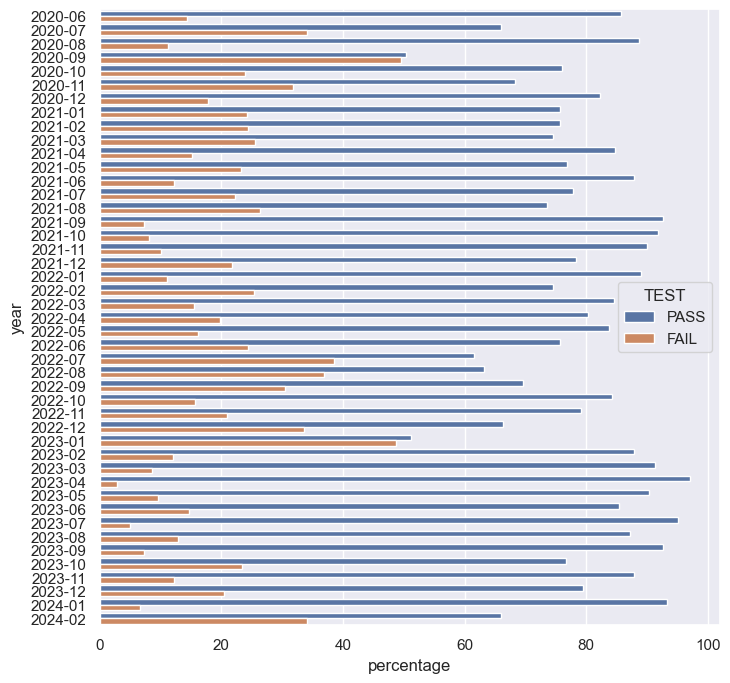

In [22]:
fig = plt.figure(figsize=(8,8))
sns.barplot(df_cal_time, x = "percentage", y = "year", hue="TEST")
plt.show()
plt.close()

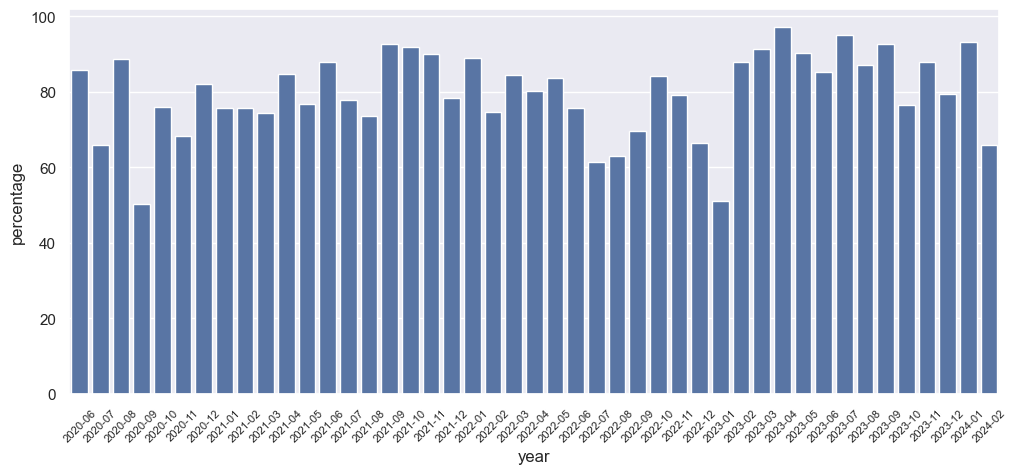

In [23]:
fig = plt.figure(figsize=(12,5))
df_cal_time_pass = df_cal_time[df_cal_time["TEST"] == "PASS"]
sns.barplot(df_cal_time_pass, x = "year", y= "percentage")
plt.xticks(rotation = 45, fontsize = 8)
plt.show()
plt.close()

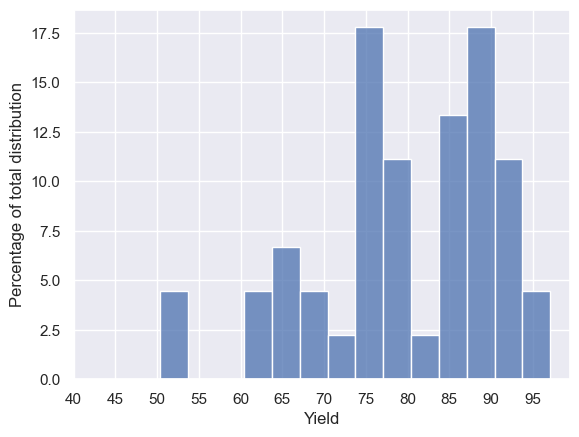

In [24]:
sns.histplot(df_cal_time_pass, x = "percentage", stat="percent", bins = 14)
plt.xticks(np.arange(40, 100, step=5))
plt.xlabel("Yield")
plt.ylabel("Percentage of total distribution")
plt.show()
plt.close()